## Solving a system of ODEs using `scipy.integrate.odeint`

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Differential equation in one variable

### **First-Order Reaction: A → B**

Let us simulate a simple **first-order irreversible reaction**:

$
\text{A} \xrightarrow{k_1} \text{B}
$

where:
- $[A](t)$ is the concentration of species A at time \(t\),
- $[B](t) = [A]_0 - [A](t)$ is the concentration of species B formed over time,
- $k_1$ is the rate constant,
- The rate law is given by:  
  $
  \frac{d[A]}{dt} = -k_1 [A]
  $

---

In [2]:
def AB_rxn(A, t, k1):
    dAdt = -k1 * A
    return dAdt

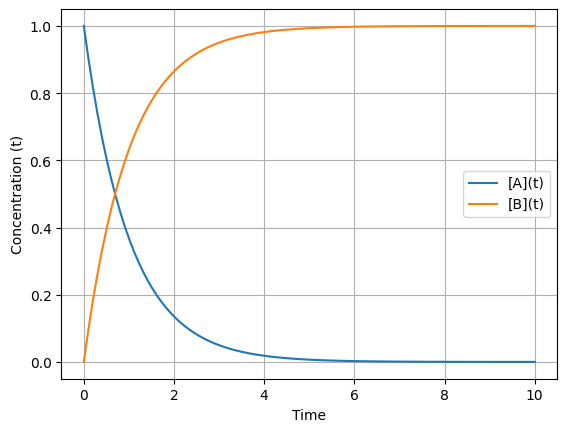

In [16]:
# Initial concentrations
A0 = 1.0

# Rate constants
k1 = 1.0

# Time 
t = np.linspace(0, 10, 100)

# Solve the differential equations
solution = odeint(AB_rxn, A0, t, args=(k1,))
# solution is A(t)

# Plot the results
plt.plot(t, solution, label='[A](t)')
# B(t) = A0 - solution
plt.plot(t, A0-solution, label='[B](t)')
plt.xlabel('Time')
plt.ylabel('Concentration (t)')
plt.grid(True)
plt.savefig("ABrxn.png",bbox_inches='tight')
plt.legend()
plt.show()

# Differential equation in multiple variables

### **Sequential First-Order Reaction: $A \rightarrow B \rightarrow C$**

This notebook simulates a **sequential reaction** involving two consecutive first-order steps:

$
A \xrightarrow{k_1} B \xrightarrow{k_2} C
$

- $[A](t)$ decreases over time as it is converted into $B$.
- $[B](t)$ first increases (from $A$) and then decreases (as it forms $C$).
- $[C](t)$ increases over time and approaches the initial amount of $A$.

The system of differential equations governing this reaction is:

$
\begin{aligned}
\frac{d[A]}{dt} &= -k_1 A \\
\frac{d[B]}{dt} &= k_1 A - k_2 B \\
\frac{d[C]}{dt} &= k_2 B
\end{aligned}
$

---

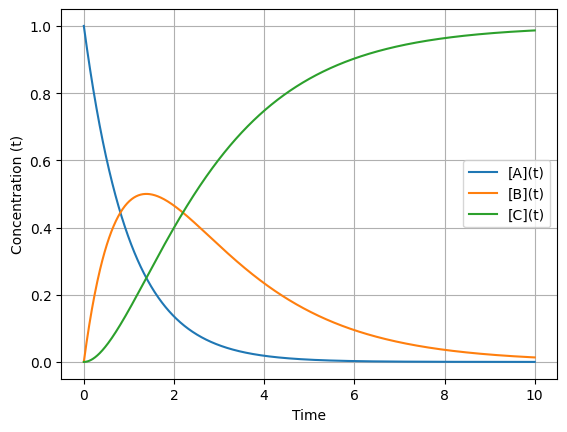

In [17]:
def ABC_rxn(y, t, k1, k2):
    A, B, C = y
    dAdt = -k1 * A
    dBdt = k1 * A - k2 * B
    dCdt = k2 * B
    return [dAdt, dBdt, dCdt]

# Initial concentrations
A0 = 1.0
B0 = 0.0
C0 = 0.0

# Rate constants
k1 = 1
k2 = 0.5

# Time 
t = np.linspace(0, 10, 1000)

# Solve the differential equations
solution = odeint(ABC_rxn, [A0, B0, C0], t, args=(k1, k2))

At = solution[:,0]

# Plot the results
plt.plot(t, At, label='[A](t)')
plt.plot(t, solution[:, 1], label='[B](t)')
plt.plot(t, solution[:, 2], label='[C](t)')
plt.xlabel('Time')
plt.ylabel('Concentration (t)')
plt.grid(True)
plt.savefig("ABCrxn.png",bbox_inches='tight')
plt.legend()
plt.show()

# Effect of rate constant and steady state approximation

The **steady state approximation (SSA)** assumes that the concentration of an intermediate (here, $B$) remains nearly constant for a period during the reaction. This occurs when:

$
\frac{d[B]}{dt} \approx 0
$

In the reaction:

$
A \xrightarrow{k_1} B \xrightarrow{k_2} C
$

the SSA is typically valid when $k_2 \gg k_1$, meaning $B$ is consumed much faster than it is produced. Under these conditions, $B$ does not accumulate significantly, and its concentration remains low and relatively constant.

---

### **How to Test SSA in the Code**

To observe the effects of the steady state approximation:

1. **Set a small value for $k_1$** (slow formation of $B$).
2. **Set a large value for $k_2$** (rapid consumption of $B$).

For example:

```python
k1 = 0.1   # Slow production of B from A
k2 = 10.0  # Fast consumption of B to form C
```

---

### **Expected Behavior under SSA**

- $[B](t)$ should remain low and flat throughout the simulation (i.e., its time derivative is approximately zero).
- $[A](t)$ decays slowly.
- $[C](t)$ increases almost linearly, directly tracking the loss of $A$.

This mimics a **quasi steady state** for the intermediate $B$.

---

### **Visual Clues in the Plot**

Under SSA conditions:
- The $[B](t)$ curve will show a small bump and then remain flat or negligible.
- The reaction appears as if $A$ is directly forming $C$, with $B$ being a short-lived intermediate.

---

In [5]:
def plot_ABC(solution,t,filename):
    # Plot the results
    plt.plot(t, solution[:, 0], label='[A](t)')
    plt.plot(t, solution[:, 1], label='[B](t)')
    plt.plot(t, solution[:, 2], label='[C](t)')
    plt.xlabel('Time')
    plt.ylabel('Concentration (t)')
    plt.grid(True)
    plt.savefig(filename,bbox_inches='tight')
    plt.legend()
    plt.show()
    
# Initial concentrations
A0 = 1.0
B0 = 0.0
C0 = 0.0

# Time 
t = np.linspace(0, 10, 1000)

### Case 1: $k_1=k_2$

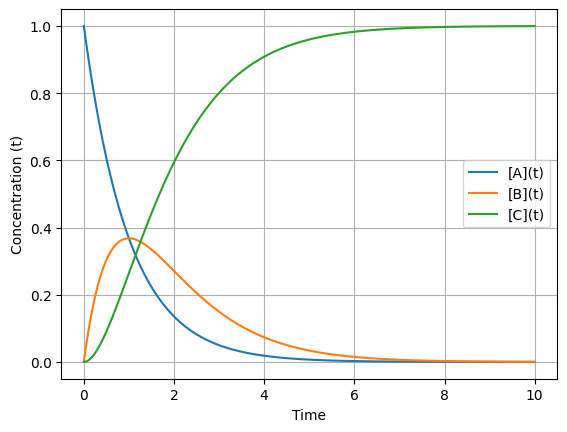

In [6]:
# Rate constants
k1 = 1
k2 = 1

# Solve the differential equations
solution = odeint(ABC_rxn, [A0, B0, C0], t, args=(k1, k2))

plot_ABC(solution,t,"ABCrxn_k1_k2_equal.png")

### Case 2: $k_1>>k_2$

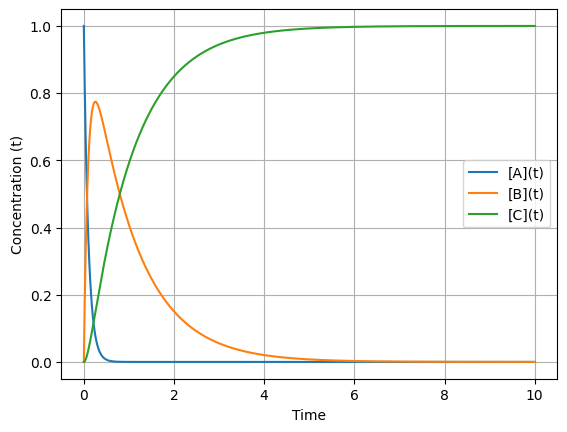

In [7]:
# Rate constants
k1 = 10
k2 = 1

# Solve the differential equations
solution = odeint(ABC_rxn, [A0, B0, C0], t, args=(k1, k2))

plot_ABC(solution,t,"ABCrxn_k1_gt_k2.png")

### Case 3: $k_2>>k_1$ when steady-state approximation is valid

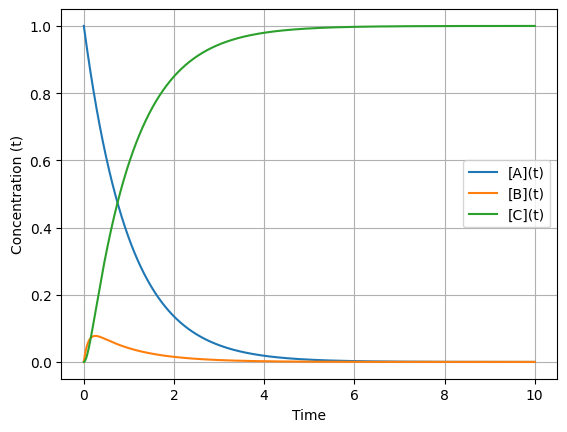

In [19]:
# Rate constants
k1 = 1
k2 = 10

# Solve the differential equations
solution = odeint(ABC_rxn, [A0, B0, C0], t, args=(k1, k2))

plot_ABC(solution,t,"ABCrxn_k1_lt_k2.png")

# Lotka-Volterra equations for predator-prey dynamics


The **Lotka–Volterra equations** describe the dynamics of biological systems in which two species interact: a **prey** and a **predator**.

The model consists of two coupled, first-order, nonlinear differential equations:

$
\begin{aligned}
\frac{dR}{dt} &= r R - a R P \quad &\text{(Prey growth - predation)} \\
\frac{dP}{dt} &= -s P + b R P \quad &\text{(Predator death + reproduction from eating prey)}
\end{aligned}
$

Where:
- $R(t)$ = number of prey (e.g., rabbits),
- $P(t)$ = number of predators (e.g., foxes),
- $r$ = natural growth rate of prey in absence of predators,
- $a$ = rate at which predators consume prey,
- $s$ = natural death rate of predators in absence of food,
- $b$ = efficiency of turning consumed prey into predator offspring.

---

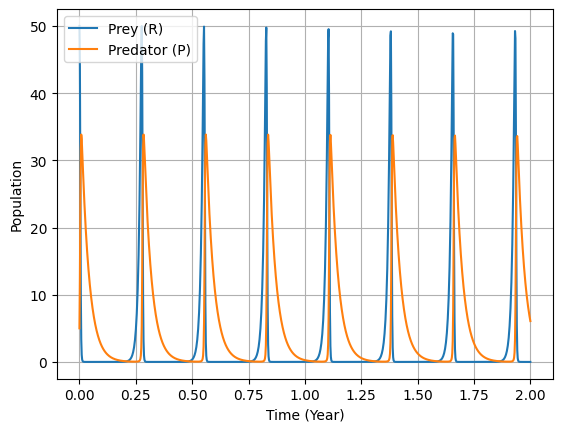

In [9]:
# Lotka-Volterra equations
def lotka_volterra(y, t, r, a, s, b):
    R, P = y
    dRdt = r * R - a * R * P
    dPdt = -s * P + b * R * P
    return [dRdt, dPdt]

# Initial populations of prey (R) and predator (P)
R0 = 50  # 50 rabbits
P0 =  5  # 5 foxes

# Rate constants
r = 100   # Prey reproduction rate, 100-per-year
a = 20    # Rate at which predators consume prey, 20-per-year
s = 30    # Predator death rate, 30-per-year
b = 10    # Rate at which predators increase by consuming prey, 10-per-year

# Time points
t = np.linspace(0, 2, 1000)

# Solve the Lotka-Volterra equations
solution = odeint(lotka_volterra, [R0, P0], t, args=(r, a, s, b))

# Plot the results
plt.plot(t, solution[:, 0], label='Prey (R)')
plt.plot(t, solution[:, 1], label='Predator (P)')
plt.xlabel('Time (Year)')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.savefig('PredatorPrey.png',bbox_inches='tight')
plt.show()


### **Introduction to Infection Models in Epidemiology**

Infectious disease modeling helps us understand how diseases spread within a population. One of the most widely used frameworks is the **compartmental model**, which divides the population into compartments based on disease status.

---

### **SIR Model: Susceptible–Infected–Recovered**

The **SIR model** is a basic model that assumes individuals in a population move through three compartments:

- **$S(t)$**: Number of **susceptible** individuals at time $t$.
- **$I(t)$**: Number of **infected** individuals at time $t$.
- **$R(t)$**: Number of **recovered** (or removed) individuals at time $t$.

The population is assumed to be **closed**, so:

$
N = S(t) + I(t) + R(t)
$

---

### **Model Equations**

The dynamics are governed by the following system of differential equations:

$
\begin{aligned}
\frac{dS}{dt} &= -\beta \frac{S I}{N} \quad &\text{(new infections)} \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I \quad &\text{(net infected)} \\
\frac{dR}{dt} &= \gamma I \quad &\text{(recoveries)}
\end{aligned}
$

Where:
- $\beta$ = transmission rate (probability of infection upon contact),
- $\gamma$ = recovery rate (fraction of infected who recover per unit time),
- $1/\gamma$ = average duration of infection.

---

### **Key Concepts**

- **Basic Reproduction Number ($R_0$):**
  
$
  R_0 = \frac{\beta}{\gamma}
$

  - If $R_0 > 1$: infection spreads.
  - If $R_0 < 1$: infection dies out.

- **Herd Immunity Threshold:**

  To stop the spread, the proportion of immune individuals must exceed:

$
  1 - \frac{1}{R_0}
$


This foundational model provides insight into **epidemic thresholds**, **peak infections**, and **long-term dynamics** of infectious disease outbreaks.

---

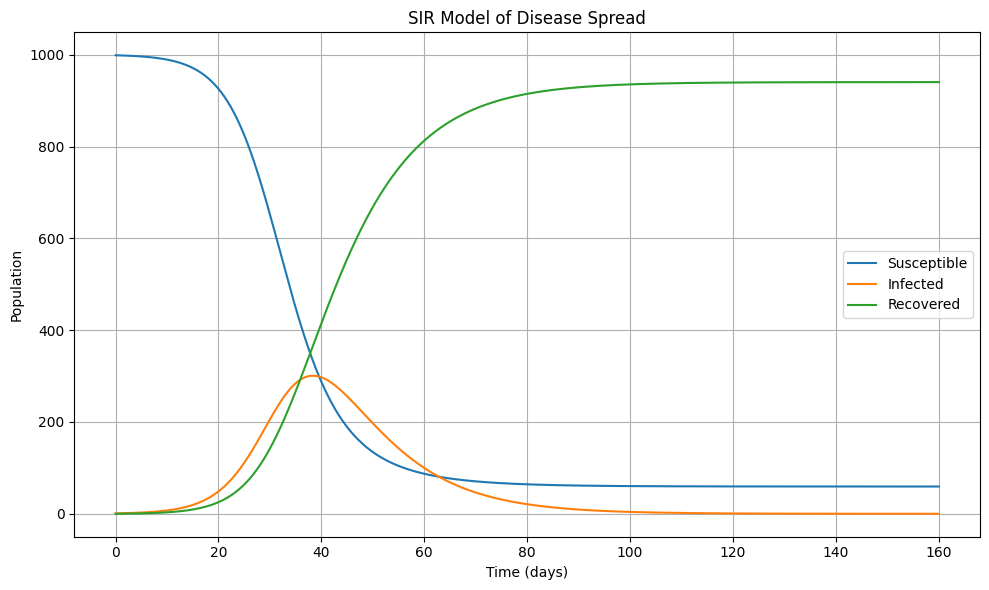

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N
N = 1000
# Initial number of infected and recovered individuals
I0, R0 = 1, 0
# Everyone else is susceptible
S0 = N - I0 - R0

# Contact rate (beta) and mean recovery rate (gamma)
beta, gamma = 0.3, 0.1

# Time grid (in days)
t = np.linspace(0, 160, 1000)

# SIR model differential equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations
solution = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = solution.T

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SIR Model of Disease Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Extensions of the SIR Model**

In real-world epidemics, the basic SIR model often needs to be modified to include additional factors. Here are some common extensions:

---

- **SIS Model**:  
  - Individuals become susceptible again after recovering.
  - There is **no lasting immunity**.
  - Useful for modeling diseases like the **common cold**.
  - Transitions:  
    $
    S \rightarrow I \rightarrow S
    $

---

- **SEIR Model**:  
  - Adds an **Exposed (E)** compartment between **S** and **I**.
  - Captures the **latency period** when an individual is infected but not yet infectious.
  - Useful for diseases like **measles** and **COVID-19**.
  - Transitions:  
    $
    S \rightarrow E \rightarrow I \rightarrow R
    $

---

- **SIRD Model**:  
  - Adds a **Death (D)** compartment.
  - Tracks the number of individuals who **die from the disease**.
  - Useful for modeling **mortality impact** during severe outbreaks.
  - Transitions:  
    $
    S \rightarrow I \rightarrow R \quad \text{and} \quad I \rightarrow D
    $

---

- **SIRV Model**:  
  - Adds a **Vaccinated (V)** compartment.
  - Models the impact of **immunization campaigns** on disease spread.
  - Individuals in the **V** group are assumed to have **permanent immunity**.
  - Transitions:  
    $
    S \rightarrow I \rightarrow R \quad \text{and} \quad S \rightarrow V
    $

---

These extensions allow for **more accurate and realistic predictions** in epidemiological modeling, especially when considering interventions, immunity waning, or fatality outcomes. One can also include the effect of lockdown as another variation. 

---


# SIR+V

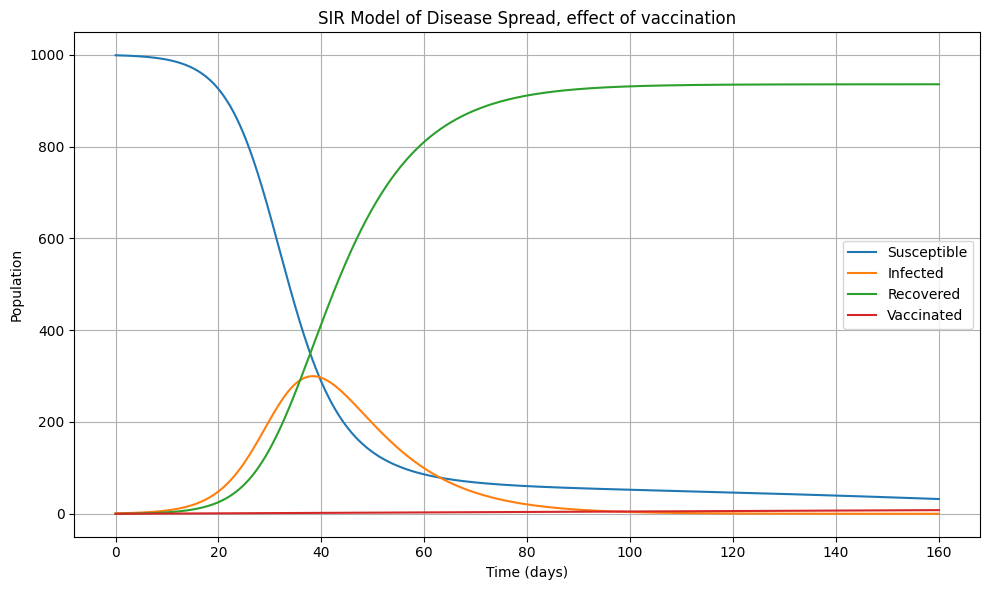

In [28]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N
N = 1000
# Initial number of infected and recovered individuals
I0, R0, V0 = 1, 0, 0
# Everyone else is susceptible
S0 = N - I0 - R0 - V0

# Contact rate (beta) and mean recovery rate (gamma)
beta, gamma = 0.3, 0.1

# Time grid (in days)
t = np.linspace(0, 160, 1000)

# SIR model differential equations
def sir_model(y, t, N, beta, gamma):
    S, I, R, V = y
    dSdt = -beta * S * I / N - 0.05 * V
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dVdt = 0.05
    return [dSdt, dIdt, dRdt, dVdt]

# Initial conditions vector
y0 = S0, I0, R0, V0

# Integrate the SIR equations
solution = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R, V = solution.T

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, V, label='Vaccinated')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SIR Model of Disease Spread, effect of vaccination')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()